##  Carbon budget

#### Libraries

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

#import functions_py.modp as mp
import fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

#### Load FATES

In [2]:
#fates = '/pscratch/sd/j/jneedham/elm_runs/dben/bia_spinup.Eb645be3aa2-F46cf01a4.2023-05-19/run/lnd/hist/bia_spinup.Eb645be3aa2-F46cf01a4.2023-05-19.elm.h0.sofar.nc'
fates = '/pscratch/sd/j/jneedham/elm_runs/dben/bia_spinup_cbudget.Eb645be3aa2-F46cf01a4.2023-08-08/run/lnd/hist/bia_spinup_cbudget.Eb645be3aa2-F46cf01a4.2023-08-08.elm.h0.sofar.nc'
fates = xr.open_dataset(fates,  decode_times=False)

nyears = int(len(fates.variables['time']))
n_lat = len(fates.variables['lat'])
n_lon = len(fates.variables['lon'])

tave_start = (nyears-5)*12
tave_stop = nyears*12

cohort_size_bins = fates.variables['fates_levscls']
patch_age_bins = fates.variables['fates_levage'][:]
nsizebins = len(cohort_size_bins)

time = fates.variables['time'] / 365.

print(len(time))

agb_frac = 0.6

21


### Does GPP = NPP + RA?  - yes (CMIP eq. 4)

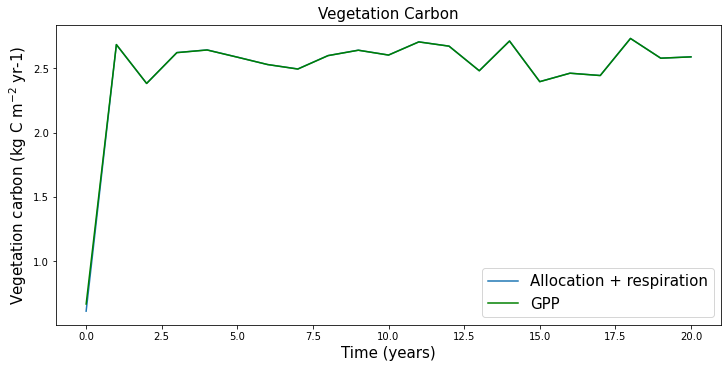

In [3]:
growth = (fates.FATES_SEED_PROD_CANOPY_SZ + fates.FATES_LEAF_ALLOC_CANOPY_SZ +
          fates.FATES_FROOT_ALLOC_CANOPY_SZ + fates.FATES_SAPWOOD_ALLOC_CANOPY_SZ + 
          fates.FATES_STRUCT_ALLOC_CANOPY_SZ + fates.FATES_SEED_ALLOC_CANOPY_SZ  + 
          fates.FATES_STORE_ALLOC_CANOPY_SZ +
          fates.FATES_SEED_PROD_USTORY_SZ + fates.FATES_LEAF_ALLOC_USTORY_SZ +
          fates.FATES_FROOT_ALLOC_USTORY_SZ + fates.FATES_SAPWOOD_ALLOC_USTORY_SZ + 
          fates.FATES_STRUCT_ALLOC_USTORY_SZ + fates.FATES_SEED_ALLOC_USTORY_SZ  + 
          fates.FATES_STORE_ALLOC_USTORY_SZ)* 31536000
growth = growth.sum(dim='fates_levscls')

respiration = (fates.FATES_GROWAR_USTORY_SZ + fates.FATES_MAINTAR_USTORY_SZ +                                                                                      
               fates.FATES_GROWAR_CANOPY_SZ + fates.FATES_MAINTAR_CANOPY_SZ) * 31536000
respiration = respiration.sum(dim='fates_levscls')

gpp = fates.FATES_GPP_PF * 31536000
gpp = gpp.sum(dim='fates_levpft')

fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(10,5), constrained_layout=True)
f1ax0.plot(time[0:120], growth[0:120] + respiration[0:120], label = 'Allocation + respiration')
f1ax0.plot(time[0:120], gpp[0:120], color='green', label = 'GPP')
f1ax0.set_title(r'Vegetation Carbon', fontsize = 15)
f1ax0.set_ylabel(r'Vegetation carbon (kg C m$^{-2}$ yr-1)', fontsize = 15)
f1ax0.set_xlabel(r'Time (years)', fontsize = 15) 
f1ax0.legend(fontsize=15)

### Does total allocation equal NPP? - yes (C4MIP eq. 3)

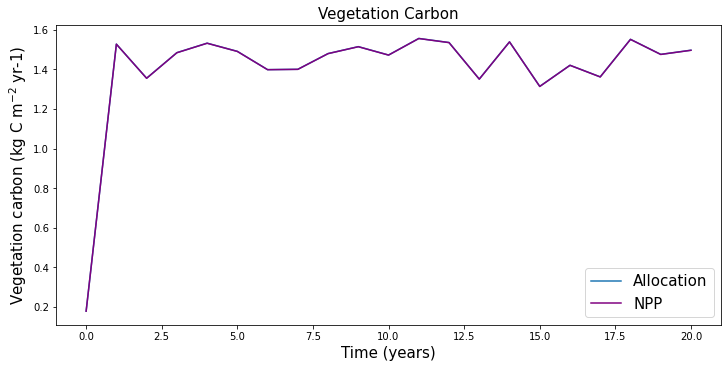

In [4]:
growth = (fates.FATES_SEED_PROD_CANOPY_SZ + fates.FATES_LEAF_ALLOC_CANOPY_SZ +
          fates.FATES_FROOT_ALLOC_CANOPY_SZ + fates.FATES_SAPWOOD_ALLOC_CANOPY_SZ + 
          fates.FATES_STRUCT_ALLOC_CANOPY_SZ + fates.FATES_SEED_ALLOC_CANOPY_SZ  + 
          fates.FATES_STORE_ALLOC_CANOPY_SZ +
          fates.FATES_SEED_PROD_USTORY_SZ + fates.FATES_LEAF_ALLOC_USTORY_SZ +
          fates.FATES_FROOT_ALLOC_USTORY_SZ + fates.FATES_SAPWOOD_ALLOC_USTORY_SZ + 
          fates.FATES_STRUCT_ALLOC_USTORY_SZ + fates.FATES_SEED_ALLOC_USTORY_SZ  + 
          fates.FATES_STORE_ALLOC_USTORY_SZ)* 31536000

growth = growth.sum(dim='fates_levscls')

npp = fates.FATES_NPP_PF * 31536000
npp = npp.sum(dim='fates_levpft')

fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(10,5), constrained_layout=True)
f1ax0.plot(time[0:120], growth[0:120], label = 'Allocation')
f1ax0.plot(time[0:120], npp[0:120], color='purple', label = 'NPP')
f1ax0.set_title(r'Vegetation Carbon', fontsize = 15)
f1ax0.set_ylabel(r'Vegetation carbon (kg C m$^{-2}$ yr-1)', fontsize = 15)
f1ax0.set_xlabel(r'Time (years)', fontsize = 15) 
f1ax0.legend(fontsize=15)

### leaf allocation v leaf turnover

''

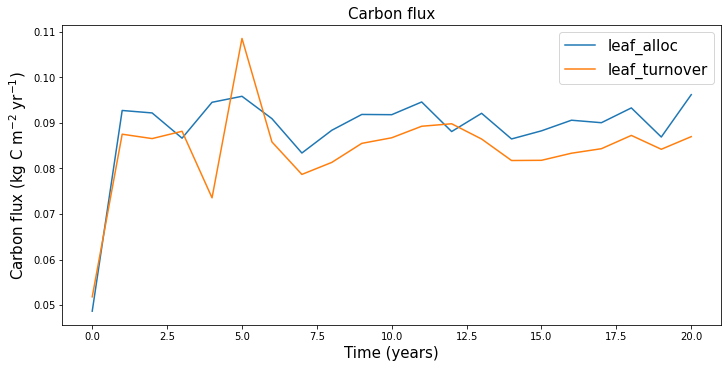

In [5]:
turnover = (fates.FATES_LEAFCTURN_CANOPY_SZ + fates.FATES_LEAFCTURN_USTORY_SZ) * 31536000
turnover = turnover.sum(dim='fates_levscls')

growth = (fates.FATES_LEAF_ALLOC_CANOPY_SZ + fates.FATES_LEAF_ALLOC_USTORY_SZ )* 31536000
growth = growth.sum(dim='fates_levscls')

fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(10,5), constrained_layout=True)

f1ax0.plot(time[0:120], growth[0:120], label = 'leaf_alloc')
f1ax0.plot(time[0:120], turnover[0:120], label = 'leaf_turnover')
f1ax0.set_title(r'Carbon flux', fontsize = 15)
f1ax0.set_ylabel(r'Carbon flux (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 15)
f1ax0.set_xlabel(r'Time (years)', fontsize = 15)  
f1ax0.legend(fontsize=15)

fig1.savefig('leaf_cflux.png')
;

### Recruit carbon budget

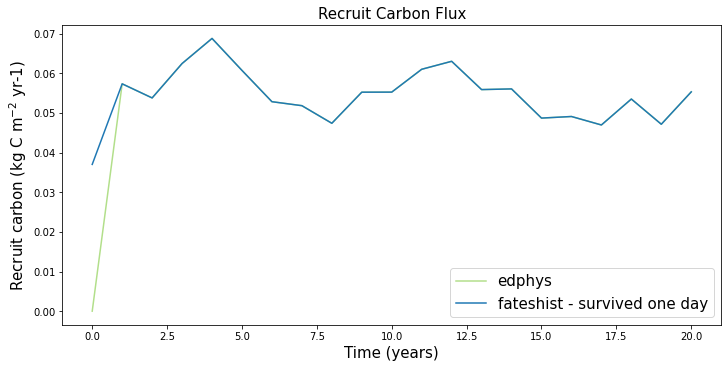

In [6]:
# site level passed to history
recruitment_cflux = fates.FATES_RECRUITMENT_CFLUX_PF.sum(dim='fates_levpft') * 31536000 

# calculated in FatesHistoryInterface
recruitment_cflux_sum = (fates.FATES_LEAF_RECRUIT_FLUX_PF + fates.FATES_FNRT_RECRUIT_FLUX_PF + 
                         fates.FATES_SAPWOOD_RECRUIT_FLUX_PF + fates.FATES_STRUCT_RECRUIT_FLUX_PF + 
                         fates.FATES_STORE_RECRUIT_FLUX_PF).sum(dim='fates_levpft') * 31536000 

fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(10,5), constrained_layout=True)
f1ax0.plot(time[0:120], recruitment_cflux[0:120], label = 'edphys', color=colormap[2])
f1ax0.plot(time[0:120], recruitment_cflux_sum[0:120], label = 'fateshist - survived one day', color=colormap[1])
f1ax0.set_title(r'Recruit Carbon Flux', fontsize = 15)
f1ax0.set_ylabel(r'Recruit carbon (kg C m$^{-2}$ yr-1)', fontsize = 15)
f1ax0.set_xlabel(r'Time (years)', fontsize = 15) 
f1ax0.legend(fontsize = 15)
fig1.savefig('recruit.png')

### Change in biomass should equal productivity (allocation and recruitment) - (mortality + turnover)

''

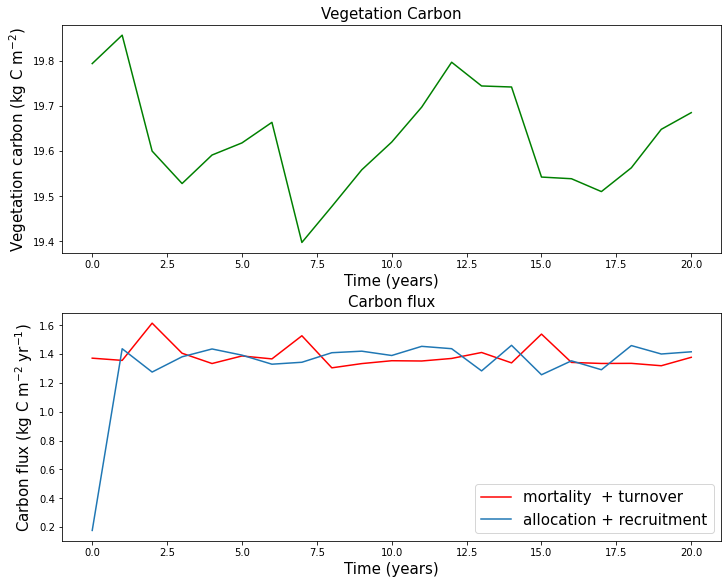

In [7]:
# Death of existing trees (not including trees that died on day one?)
cmort = fates.FATES_MORTALITY_CFLUX_PF * 365 * 86400
cmort_tot = cmort.sum(dim='fates_levpft')

# turnover of tissues 
turnover = (fates.FATES_LEAFCTURN_CANOPY_SZ + fates.FATES_FROOTCTURN_CANOPY_SZ + 
            fates.FATES_STORECTURN_CANOPY_SZ + fates.FATES_STRUCTCTURN_CANOPY_SZ + 
            fates.FATES_SAPWOODCTURN_CANOPY_SZ +  
            fates.FATES_LEAFCTURN_USTORY_SZ + fates.FATES_FROOTCTURN_USTORY_SZ + 
            fates.FATES_STORECTURN_USTORY_SZ + fates.FATES_STRUCTCTURN_USTORY_SZ + 
            fates.FATES_SAPWOODCTURN_USTORY_SZ) * 365 * 86400 
turnover = turnover.sum(dim='fates_levscls') 

#seed_decay  =  fates.FATES_SEED_DECAY_EL.sum(dim='fates_level')  * 365  * 86400 


# recruitment of new plants (not including those that died on day one?)
recruits = fates.FATES_RECRUITMENT_CFLUX_PF.sum(dim='fates_levpft') * 365 * 86400

# growth of existing plants - NOT including production of new seeds
growth = (#fates.FATES_SEED_PROD_CANOPY_SZ + fates.FATES_SEED_ALLOC_CANOPY_SZ  + # is this double counting?
          fates.FATES_FROOT_ALLOC_CANOPY_SZ + fates.FATES_LEAF_ALLOC_CANOPY_SZ +
          fates.FATES_STRUCT_ALLOC_CANOPY_SZ + fates.FATES_SAPWOOD_ALLOC_CANOPY_SZ + 
          fates.FATES_STORE_ALLOC_CANOPY_SZ +
         # fates.FATES_SEED_PROD_USTORY_SZ + fates.FATES_SEED_ALLOC_USTORY_SZ  + 
          fates.FATES_FROOT_ALLOC_USTORY_SZ + fates.FATES_LEAF_ALLOC_USTORY_SZ +
          fates.FATES_STRUCT_ALLOC_USTORY_SZ + fates.FATES_SAPWOOD_ALLOC_USTORY_SZ + 
          fates.FATES_STORE_ALLOC_USTORY_SZ) * 365 * 86400
growth = growth.sum(dim='fates_levscls') 

vegc = fates.FATES_VEGC_PF
vegc = vegc.sum(dim='fates_levpft')

fig1, ((f1ax0, f1ax1)) = plt.subplots(nrows=2,ncols=1, figsize=(10,8), constrained_layout=True)

f1ax0.plot(time, vegc, color='green')
f1ax0.set_title(r'Vegetation Carbon', fontsize = 15)
f1ax0.set_ylabel(r'Vegetation carbon (kg C m$^{-2}$)', fontsize = 15)
f1ax0.set_xlabel(r'Time (years)', fontsize = 15) 

f1ax1.plot(time, cmort_tot + turnover, label = 'mortality  + turnover', color='red')
f1ax1.plot(time, growth + recruits, label = 'allocation + recruitment')
f1ax1.set_title(r'Carbon flux', fontsize = 15)
f1ax1.set_ylabel(r'Carbon flux (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 15)
f1ax1.set_xlabel(r'Time (years)', fontsize = 15)  
f1ax1.legend(fontsize=15)

fig1.savefig('Cflux.png')
;

#### Biomass t1 - t0 = total growth - total turnover

In [8]:
netc = (growth + recruits) - (cmort_tot + turnover)
print(netc.shape)

(21, 1)


In [9]:
deltabiomass = [x - vegc[i - 1] for i, x in enumerate(vegc)][1:]
print(len(deltabiomass))

20


''

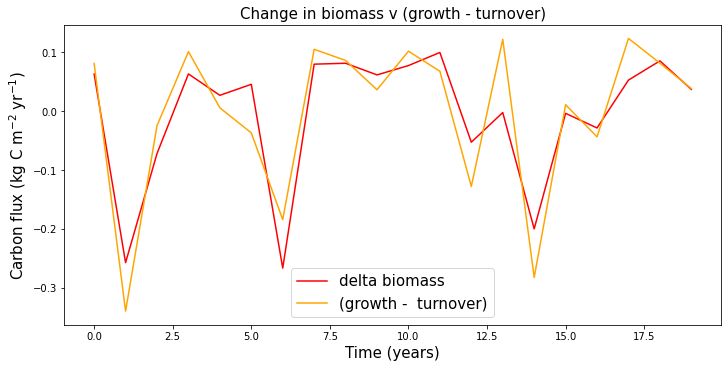

In [10]:
fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(10,5), constrained_layout=True)

f1ax0.plot(time[0:20], deltabiomass, label = 'delta biomass', color='red')
f1ax0.plot(time[0:20], netc[1:], label = '(growth -  turnover)', color='orange')
f1ax0.set_title(r'Change in biomass v (growth - turnover)', fontsize = 15)
f1ax0.set_ylabel(r'Carbon flux (kg C m$^{-2}$ yr$^{-1}$)', fontsize = 15)
f1ax0.set_xlabel(r'Time (years)', fontsize = 15)  
f1ax0.legend(fontsize=15)
;

''

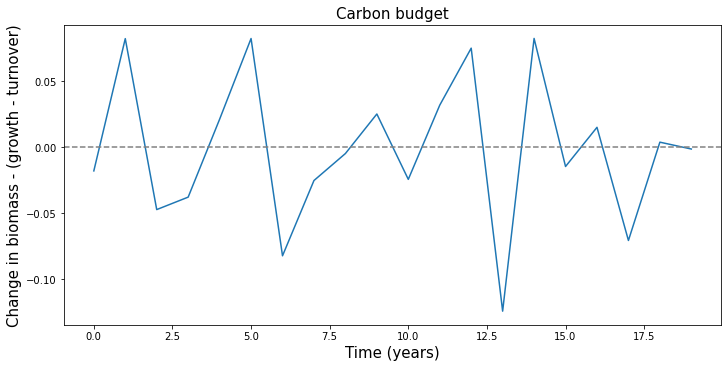

In [11]:
fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(10,5), constrained_layout=True)

f1ax0.plot(time[0:20], deltabiomass - netc[1:])
f1ax0.set_title(r'Carbon budget', fontsize = 15)
f1ax0.set_ylabel(r'Change in biomass - (growth - turnover)', fontsize = 15)
f1ax0.set_xlabel(r'Time (years)', fontsize = 15)  
f1ax0.axhline(y=0, linestyle = '--', color = 'grey')
;